In [36]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.utils as util
import os
from os.path import exists
from tqdm import tqdm
import numpy as np

from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import SimpleRNN

import matplotlib.pyplot as plt


In [4]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
!ls "/content/drive/MyDrive/ColabNotebooks/NLP/data/macmorpho-v3"

macmorpho-dev.txt  macmorpho-test.txt  macmorpho-train.txt


## CONSTANTS

In [239]:
PATH_DATA = '/content/drive/MyDrive/ColabNotebooks/NLP/data/macmorpho-v3'
FILE_DATA_TRAIN = '{0}/macmorpho-train.txt'.format(PATH_DATA) 
FILE_DATA_TEST = '{0}/macmorpho-test.txt'.format(PATH_DATA) 

MAX_WORDS_SENTENCES = 250 #this number was obtained after analyzing the sentences
#MAX_WORDS_SENTENCES = 100
EMBEDDING_NAME = 'skip_s50.zip'
EMBEDDING_SIZE = 50

# LOAD DATA (macmorpho-v3)

In [15]:
def load_data_to_list(path):
  X = []
  Y = []

  with open(path, 'r') as f:
    lines = f.readlines()

  for line in lines:
    result = line.split(' ')
    X.append([l.split('_')[0].lower() for l in result])
    Y.append([l.split('_')[1].lower().replace('\n','') for l in result])

  return X, Y

In [16]:
def get_all_tags(vec):
  dict_tags = {}
  
  for tags in vec:
    for tag in tags:
      tag = tag.replace('+','').replace('-','')
      if tag not in dict_tags:
        dict_tags[tag] = 1
      else:
        dict_tags[tag] += 1
    
  return dict_tags

In [240]:
TRAIN_SENTENCES, TRAIN_TAGS = load_data_to_list(FILE_DATA_TRAIN)
TEST_SENTENCES, TEST_TAGS = load_data_to_list(FILE_DATA_TEST)

#JOIN
ALL_SENTENCES = []
ALL_SENTENCES.extend(TRAIN_SENTENCES)
ALL_SENTENCES.extend(TEST_SENTENCES)

print(TRAIN_SENTENCES[0])
print(TEST_SENTENCES[0])

['jersei', 'atinge', 'média', 'de', 'cr$', '1,4', 'milhão', 'na', 'venda', 'da', 'pinhal', 'em', 'são', 'paulo', '.']
['salto', 'sete']


In [241]:
TRAIN_TAGS_COUNT = get_all_tags(TRAIN_TAGS)
TEST_TAGS_COUNT = get_all_tags(TEST_TAGS)
ALL_TAGS_COUNT = {k: v + TEST_TAGS_COUNT[k] for k,v in TRAIN_TAGS_COUNT.items()}

NUMBER_TAGS = len(ALL_TAGS_COUNT)
print('ALL_TAGS: ', NUMBER_TAGS)
print(ALL_TAGS_COUNT)

ALL_TAGS:  26
{'n': 192663, 'v': 95646, 'prep': 87537, 'cur': 2359, 'num': 15485, 'prepart': 55909, 'nprop': 87966, 'pu': 133138, 'proadj': 14816, 'proks': 10473, 'adj': 41427, 'kc': 22439, 'art': 65719, 'ks': 11647, 'pcp': 18722, 'adv': 23855, 'propess': 11110, 'prepproadj': 1649, 'pden': 5427, 'prosub': 6120, 'preppropess': 514, 'advks': 1007, 'prepproks': 209, 'prepprosub': 680, 'in': 272, 'prepadv': 81}


# PREPARE DATA

In [242]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(ALL_SENTENCES)

X_TRAIN = word_tokenizer.texts_to_sequences(TRAIN_SENTENCES) 
X_TEST = word_tokenizer.texts_to_sequences(TEST_SENTENCES) 

X_TRAIN = pad_sequences(X_TRAIN, maxlen = MAX_WORDS_SENTENCES, padding="pre", truncating="post")
X_TEST = pad_sequences(X_TEST, maxlen = MAX_WORDS_SENTENCES, padding="pre", truncating="post")

In [243]:
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
#VOCABULARY_SIZE = 5000

In [244]:
tags_tokenizer = Tokenizer()
tags_tokenizer.fit_on_texts([k for k in ALL_TAGS_COUNT])

Y_TRAIN = tags_tokenizer.texts_to_sequences(TRAIN_TAGS) 
Y_TEST = tags_tokenizer.texts_to_sequences(TEST_TAGS) 

Y_TRAIN = pad_sequences(Y_TRAIN, maxlen = MAX_WORDS_SENTENCES, padding="pre", truncating="post")
Y_TEST = pad_sequences(Y_TEST, maxlen = MAX_WORDS_SENTENCES, padding="pre", truncating="post")

print(len(Y_TRAIN))
print(tags_tokenizer.word_index)

37948
{'n': 1, 'v': 2, 'prep': 3, 'cur': 4, 'num': 5, 'prepart': 6, 'nprop': 7, 'pu': 8, 'proadj': 9, 'proks': 10, 'adj': 11, 'kc': 12, 'art': 13, 'ks': 14, 'pcp': 15, 'adv': 16, 'propess': 17, 'prepproadj': 18, 'pden': 19, 'prosub': 20, 'preppropess': 21, 'advks': 22, 'prepproks': 23, 'prepprosub': 24, 'in': 25, 'prepadv': 26}


In [245]:
len(to_categorical(Y_TEST, 26)[0][0])

26

In [246]:
Y_TRAIN = util.np_utils.to_categorical(Y_TRAIN)
Y_TEST = util.np_utils.to_categorical(Y_TEST)

NUM_CLASSES = Y_TRAIN.shape[2]
print(Y_TRAIN.shape)

(37948, 250, 26)


In [247]:

print(Y_TEST[0])

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Load Embedding

In [23]:
if exists('sample_data/{0}'.format('skip_s50.zip')) == False:
    !wget http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s50.zip -O sample_data/skip_s50.zip
    !unzip sample_data/skip_s50.zip

--2022-01-21 07:37:34--  http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s50.zip
Connecting to 143.107.183.175:22980... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176485664 (168M) [application/octet-stream]
Saving to: ‘sample_data/skip_s50.zip’

sample_data/skip_s5 100%[===================>] 168.31M  9.08MB/s    in 18s     

2022-01-21 07:37:52 (9.54 MB/s) - ‘sample_data/skip_s50.zip’ saved [176485664/176485664]

gzip: sample_data/skip_s50.zip: unknown suffix -- ignored


In [24]:
!unzip sample_data/skip_s50.zip

Archive:  sample_data/skip_s50.zip
  inflating: skip_s50.txt            


In [190]:
def load_word_embedding(word_index, dimension_embedding):
    dic_embedding = {}
    
    file_embedding = open(os.path.join('sample_data', "skip_s{}.txt".format(dimension_embedding)), encoding='utf-8')
    
    #Carregando os WordEmbeddings para um dicionario
    for line in tqdm(file_embedding):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefficient = np.asarray(values[1:], dtype='float32')
        dic_embedding[word] = coefficient
            
    file_embedding.close()
    
    #Cria a matrix com em que serão carregados os embeddings
    matrix_embedding = np.zeros((VOCABULARY_SIZE, dimension_embedding))
    
    for word, i in word_index.items():
        if i >= VOCABULARY_SIZE:
            continue
        
        vector_embedding = dic_embedding.get(word)
        
        if vector_embedding is not None:
            matrix_embedding[i] = vector_embedding

    return matrix_embedding

In [248]:
MATRIX_EMBEDDING = load_word_embedding(word_tokenizer.word_index, EMBEDDING_SIZE)

929607it [00:13, 66642.92it/s]


#RNN - Model

In [249]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_WORDS_SENTENCES,          # length of input sequence
                        weights       =  [MATRIX_EMBEDDING],
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, #64 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [250]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [251]:
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 50)           2660100   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 250, 64)           7360      
                                                                 
 time_distributed_3 (TimeDis  (None, 250, 26)          1690      
 tributed)                                                       
                                                                 
Total params: 2,669,150
Trainable params: 9,050
Non-trainable params: 2,660,100
_________________________________________________________________


In [252]:
rnn_training = rnn_model.fit(X_TRAIN, Y_TRAIN, batch_size=128, epochs=10, validation_data=(X_TEST, Y_TEST))

Epoch 1/10
297/297 [==============================] - 59s 197ms/step - loss: 0.3674 - acc: 0.9252 - val_loss: 0.1849 - val_acc: 0.9541
Epoch 2/10
297/297 [==============================] - 57s 193ms/step - loss: 0.1770 - acc: 0.9539 - val_loss: 0.1586 - val_acc: 0.9580
Epoch 3/10
297/297 [==============================] - 58s 194ms/step - loss: 0.1573 - acc: 0.9562 - val_loss: 0.1438 - val_acc: 0.9593
Epoch 4/10
297/297 [==============================] - 58s 195ms/step - loss: 0.1456 - acc: 0.9573 - val_loss: 0.1344 - val_acc: 0.9601
Epoch 5/10
297/297 [==============================] - 58s 195ms/step - loss: 0.1379 - acc: 0.9580 - val_loss: 0.1279 - val_acc: 0.9607
Epoch 6/10
297/297 [==============================] - 58s 194ms/step - loss: 0.1325 - acc: 0.9584 - val_loss: 0.1236 - val_acc: 0.9610
Epoch 7/10
297/297 [==============================] - 57s 192ms/step - loss: 0.1288 - acc: 0.9587 - val_loss: 0.1204 - val_acc: 0.9613
Epoch 8/10
297/297 [==============================] - 5

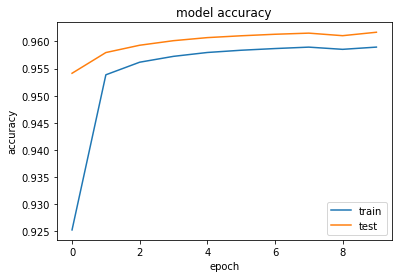

In [253]:
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [197]:
len(Y_TRAIN)

37948

In [42]:
y_classes = [np.argmax(y, axis=None, out=None) for y in Y_TRAIN]


In [254]:
predicted_values = rnn_model.predict(X_TEST)

In [255]:
predicted_values[0][97]

array([9.9953735e-01, 1.1097853e-04, 2.1578899e-05, 1.6791211e-05,
       4.4673493e-06, 4.0217612e-05, 4.0763985e-06, 4.1726242e-05,
       5.1524046e-05, 1.3825647e-05, 5.8308633e-06, 1.4738564e-05,
       6.2285590e-06, 2.2136939e-05, 5.7250409e-06, 5.2779192e-06,
       1.7400736e-05, 1.7039652e-05, 8.7947064e-06, 5.0767508e-06,
       5.2746782e-06, 1.5478108e-06, 3.9997581e-06, 4.9220107e-06,
       4.2481242e-06, 2.9352925e-05], dtype=float32)

In [229]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        
        for categorical in categorical_sequence:
          #print(np.argmax(categorical))
          #print(index)
          #break
          
          if np.argmax(categorical) != 0:
            #print(categorical_sequence)
            token_sequence.append(index[np.argmax(categorical)])
            #break
        #break
        token_sequences.append(token_sequence)
 
    return token_sequences

  #https://nlpforhackers.io/lstm-pos-tagger-keras/

In [256]:
predicted_tags = logits_to_tokens(s, {i: t for t, i in tags_tokenizer.word_index.items()})

In [258]:
print(len(predicted_tags[0]))
print(len(TEST_TAGS[2]))

print(predicted_tags[2])
print(TEST_TAGS[2])

0
12
['n', 'v', 'v', 'n', 'prep', 'n', 'n', 'n', 'pu']
['n', 'adj', 'adj', 'pu', 'v', 'adj', 'pcp', 'prep', 'n', 'prep', 'n', 'pu']


In [232]:
print(np.argmax((s[1][247])))
print(s[1][247])

8
[8.5003412e-06 5.6491531e-02 1.3507596e-02 5.6608949e-02 3.2062365e-03
 1.0007101e-02 1.3731036e-03 3.5226092e-02 7.4478388e-01 5.0461832e-03
 1.1891684e-03 1.2036162e-02 1.5894692e-02 8.6490996e-03 3.4121280e-03
 3.3440485e-03 8.2594454e-03 1.6276413e-03 1.2740389e-03 2.9854449e-03
 1.9711193e-03 2.7417336e-03 1.4530276e-03 2.3786929e-03 2.2948955e-03
 4.2294511e-03]


In [107]:
print(rr[2])
print(TEST_TAGS[2])
print(X_TEST[2])
print(word_tokenizer.word_index)

['pu', 'v', 'n', 'nprop', 'n', 'n', 'n', 'n', 'pu']
['n', 'adj', 'adj', 'pu', 'v', 'adj', 'pcp', 'prep', 'n', 'prep', 'n', 'pu']
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0  

In [89]:
tags_tokenizer.word_index

{'adj': 11,
 'adv': 16,
 'advks': 22,
 'art': 13,
 'cur': 4,
 'in': 25,
 'kc': 12,
 'ks': 14,
 'n': 1,
 'nprop': 7,
 'num': 5,
 'pcp': 15,
 'pden': 19,
 'prep': 3,
 'prepadv': 26,
 'prepart': 6,
 'prepproadj': 18,
 'prepproks': 23,
 'preppropess': 21,
 'prepprosub': 24,
 'proadj': 9,
 'proks': 10,
 'propess': 17,
 'prosub': 20,
 'pu': 8,
 'v': 2}

In [72]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)
 

NameError: ignored